In [48]:

%load_ext autoreload
%autoreload 2

import os
from datetime import datetime
import glob
import pandas as pd
import matplotlib.pyplot as plt
import torch
from torch.utils.data import DataLoader
from torch.optim import Adam
from torch.utils.tensorboard import SummaryWriter

from market_dynamics import bs_delta, bs_generator, bs_call_price
from get_data import get_option_data
from data import SimulationData
from utils import call_payoff, stochastic_integral
from models import ControlNet
from train import train, test
from evaluation import get_eval_data

import seaborn as sns

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [49]:
current_time = datetime.now().strftime('%b%d_%H-%M-%S')
comment = ""
log_dir = os.path.join('experiments', current_time + '_' + comment)
writer = SummaryWriter(log_dir)

In [50]:
option_dfs = {}
for file_name in glob.glob("data/"+'*.csv'):
    option_id = file_name[5:-4]
    option_dfs[option_id]  = pd.read_csv(file_name, index_col=0)

In [51]:
option_df = option_dfs[option_id]
option_df.head()

,secid,date,exdate,last_date,cp_flag,strike_price,best_bid,best_offer,volume,impl_volatility,optionid,forward_price,index_flag,issuer,exercise_style,S
1580744,112878,2014-01-23,20140517,20140123.0,C,820000,13.8,16.3,1,0.116460,102586106,NaN,1,CBOE S&P 100 INDEX,E,818.460022
1582036,112878,2014-01-24,20140517,20140123.0,C,820000,10.7,12.3,0,0.130208,102586106,NaN,1,CBOE S&P 100 INDEX,E,812.130005
1583242,112878,2014-01-27,20140517,20140127.0,C,820000,8.6,10.8,1,0.127482,102586106,NaN,1,CBOE S&P 100 INDEX,E,796.280029
1584448,112878,2014-01-28,20140517,20140127.0,C,820000,8.3,10.4,0,0.119698,102586106,NaN,1,CBOE S&P 100 INDEX,E,792.510010
1585654,112878,2014-01-29,20140517,20140127.0,C,820000,6.4,8.4,0,0.122803,102586106,NaN,1,CBOE S&P 100 INDEX,E,795.500000


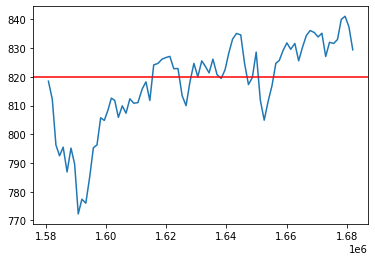

In [52]:
option_df.S.plot()
plt.axhline(y=option_df["strike_price"].iloc[0] / 1000, color='r', linestyle='-')

In [53]:
# Get params dependent on data
strike, sigma, n_steps, initial_value, x, x_inc, payoff, price = get_eval_data(option_df)

In [59]:
# Remaining params to determine
n_simulations = 10_000
rf = 0
fc_dims = [16, 16]
LR = 0.005
EPOCHS = 20

In [60]:
# Using implied volatility should give back market price 
price, bs_call_price(n_steps, initial_value, sigma, rf, strike)

(15.05, 20.54619183494765)

In [61]:
bs_params = {"n_simulations": n_simulations,
             "n_steps": n_steps,
             "initial_value": initial_value,
             "sigma": sigma,
             }

price_params = {"n_steps": n_steps,
                "initial_value": initial_value,
                "sigma": sigma,
                "rf": rf,
                "strike": strike,
                }

payoff_params = {"strike": strike}


dt = SimulationData(bs_generator, bs_params, lambda x: x, {"x": price}, call_payoff, payoff_params)
data_loader_train = DataLoader(dt, batch_size=20, shuffle=True)
cn = ControlNet(n_steps, 1, fc_dims, 1)

optimizer = Adam(cn.parameters(), lr=LR)
criterion = torch.nn.MSELoss()
train(data_loader_train, cn, criterion , optimizer, EPOCHS, writer)

Epoch 0: : 0batch [00:00, ?batch/s]/root/projects/uni/fml/FML/venv/lib/python3.8/site-packages/torch/nn/modules/loss.py:528: UserWarning: Using a target size (torch.Size([20])) that is different to the input size (torch.Size([20, 20])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
Epoch 0: : 500batch [00:29, 16.81batch/s, loss=8.9e+4]
Epoch 1: : 500batch [00:30, 16.23batch/s, loss=1.3e+3]
Epoch 2: : 500batch [00:32, 15.18batch/s, loss=1.53e+4]
Epoch 3: : 500batch [00:31, 15.91batch/s, loss=1.01e+4]
Epoch 4: : 500batch [00:31, 15.98batch/s, loss=8.75e+3]
Epoch 5: : 500batch [00:31, 15.98batch/s, loss=4.62e+3]
Epoch 6: : 500batch [00:36, 13.87batch/s, loss=7.9e+3]
Epoch 7: : 500batch [00:45, 11.11batch/s, loss=799]
Epoch 8: : 500batch [00:36, 13.81batch/s, loss=2.76e+3]
Epoch 9: : 500batch [00:29, 17.24batch/s, loss=967]
Epoch 10: : 500batch [00:28, 17.66batch/s, loss=76

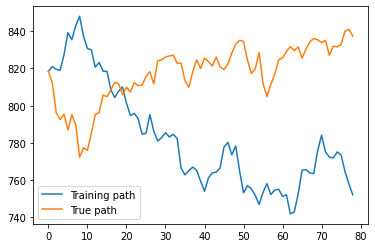

In [62]:
# Visualize an example training path and the true path

a, b, c, d, = next(iter(data_loader_train))
plt.plot(a[0], label="Training path")
plt.plot(x.squeeze(), label="True path")
plt.legend()

In [63]:
# Model
hedge = cn(torch.Tensor(x))
si = stochastic_integral(torch.Tensor(x_inc), hedge)
model_loss = (price + si - payoff) ** 2
print(f"{model_loss=}")

# Delta hedge benchmark
def delta(x):
    return bs_delta(n_steps, x, sigma, rf, strike)

d_hedge = torch.Tensor([delta(i) for i in x.squeeze()])
si = stochastic_integral(x_inc, d_hedge)
delta_loss = (price + si - payoff) ** 2
print(f"{delta_loss=}")

model_loss=tensor(19.8862, grad_fn=<PowBackward0>)
delta_loss=tensor(1.7756)


In [46]:
delta(800)

-0.34608083470050505

In [45]:
price + si - payoff

tensor(-20.4646)

In [25]:
si

tensor(-26.1346)

In [27]:
(price - payoff) ** 2

32.1488446289301

In [33]:
d_hedge[0]

tensor(0.0038)